In [1]:
import numpy as np
import math
import torch
import sys
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

In [2]:
if sys.platform == "darwin":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mps


## Q 3.1

### Logistic Regression

In [3]:
# Create dataloaders
n_iters = 50000

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

class LinearLogisticRegression(torch.nn.Module):
    def __init__(self, input_features):
        super(LinearLogisticRegression, self).__init__()
        self.input_features = input_features
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_features, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, self.input_features)
        return self.layers(x)

class KernelLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

class LinearSVM(torch.nn.Module):
    def __init__(self, input_features):
        super(LinearSVM, self).__init__()
        self.input_features = input_features
        self.layers = torch.nn.Sequential(torch.nn.Linear(input_features, 1, bias=True))
        return

    def weights(self):
        return self.layers[0].state_dict()['weight']

    def forward(self, x):
        x = x.view(-1, self.input_features)
        return self.layers(x)

class KernelSVM(torch.nn.Module):
    def __init__(self, training_data, kernel='rbf', sigma = 1/math.sqrt(1/50)):
        super().__init__()
        self.training_data = training_data
        
        if kernel == 'linear':
            self.kernel_func = self.linear
            self.layers = torch.nn.Sequential(torch.nn.Linear(len(training_data), 1))
        elif kernel == 'polynomial':
            self.kernel_func = self.polynomial
        elif kernel == 'rbf':
            self.kernel_func = self.rbf
            self.sigma = torch.nn.Parameter(torch.FloatTensor([sigma]))
            self.layers = torch.nn.Sequential(torch.nn.Linear(len(training_data), 1))
            
        else:
            print("Invalid Kernel choice")
            exit()
    
    def weights(self):
        return self.layers[0].state_dict()['weight']
    
    def rbf(self, x, y):
        x_pairwise_dist = torch.square(torch.cdist(x, y, p=2)/self.sigma)
        return torch.exp(-0.5 * x_pairwise_dist)

    def polynomial(self, x):
        return x

    def linear(self, x):
        return x

    def forward(self, x):
        kernel_input = self.kernel_func(x, self.training_data)
        return self.layers(kernel_input)

## Q 3.2

In [4]:
# Create Dataset
mu = torch.tensor([2.5, 0])
a  = []
b = []
positive_example_sampler = torch.distributions.MultivariateNormal(mu, torch.eye(2))
negative_example_sampler = torch.distributions.MultivariateNormal(-mu, torch.eye(2))
for _ in range(750):
    a.append(positive_example_sampler.sample().view(1,2))
    b.append(negative_example_sampler.sample().view(1,2))

postive_data_points = torch.stack(a).view(750, 2)
negative_data_points = torch.stack(b).view(750, 2)
data_set = torch.cat((postive_data_points, negative_data_points))
labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
shuffle_index = torch.randperm(data_set.shape[0])
data_set = data_set[shuffle_index]
labels = labels[shuffle_index]
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]] 

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

In [5]:
def get_prediction(model, data):
    return model(data).detach()

def get_accuracy(predictions, labels):
    threshold = torch.tensor([0.5])
    predictions = (predictions >= threshold).float()*1
    return float(torch.count_nonzero((labels == predictions)))/float(len(labels))

def report_acc_decision_boundary(model, test_set_loader):
    for data, labels in test_set_loader:
        predictions = get_prediction(model, data)
        accuracy = get_accuracy(predictions, labels)
        print(f" Accuracy of model on test set: {accuracy*100}%")
    return

def draw_decision_boundary(model, test_dataset):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()

    x_min, x_max = test_set.data.min() - 1, test_set.data.max() + 1
    y_min, y_max = test_set.data.min() - 1, test_set.data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05).astype(np.float32),
                        np.arange(y_min, y_max, 0.05).astype(np.float32))
    preds = get_prediction(model, torch.hstack((torch.from_numpy(xx.ravel()).view(len(xx.ravel()), 1), torch.from_numpy(yy.ravel()).view(len(xx.ravel()), 1))))
    threshold = torch.tensor([0.5])
    preds = (preds >= threshold).float()*1
    preds = preds.reshape(xx.shape)
    plt.contourf(xx, yy, preds, cmap='Paired_r', alpha=0.5)
    plt.contour(xx, yy, preds, colors='k', linewidths=0.7)

    ax.scatter(test_dataset.data[:, 0], test_dataset.data[:, 1], c=test_dataset.labels ,cmap = clrs.ListedColormap(["red", "blue"]))
    plt.title("Decision Boundary")

    plt.show()
    return

def train_logistic_regression(model, train_loader, validation_loader, learning_rate, losses, debug=False, epochs=10000):
    criterion = torch.nn.BCELoss(reduction='mean')
    threshold = 1e-6
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    epoch = 1

    while abs(loss_reduction) >= threshold :
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
            curr_loss =  criterion(val_predictions, val_labels)
        loss_reduction = curr_loss.item()/prev_loss - 1.0
        prev_loss = curr_loss.item()
        losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch += 1

    # Evaluate on validation set
    validation_accuracy = 0.
    for val_data, val_labels in validation_loader:
        val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
        validation_accuracy = get_accuracy(val_predictions, val_labels)
    print(f" Validation Set accuracy is: {validation_accuracy*100}")
    
    return

def svm_loss(w, y_hat, y, reg_param):
    return reg_param * torch.mean(torch.clamp(1 -  (2*y - 1)  * y_hat, min=0)) + torch.sum(torch.square(w))*0.5

def train_linear_svm(model, train_loader, validation_loader, learning_rate, reg_param, losses, debug=False, epochs=10000):
    threshold = 1e-4
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    
    epoch = 1
    while abs(loss_reduction) >= threshold :
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x).view(x.shape[0], 1)
            #Get weights of the linear layer
            params = model.weights()
            loss = svm_loss(params, y_hat, y, reg_param)
            optim.zero_grad()
            (loss).backward()
            optim.step()
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
            curr_loss =  svm_loss(model.weights(), val_predictions, val_labels, reg_param)
        loss_reduction = curr_loss.item()/prev_loss - 1.0
        prev_loss = curr_loss.item()
        losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch +=1

    # Evaluate on validation set
    validation_accuracy = 0.
    for val_data, val_labels in validation_loader:
        val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
        validation_accuracy = get_accuracy(val_predictions, val_labels)
    print(f" Validation Set accuracy is: {validation_accuracy*100}")
    
    return


def train_kernel_svm(model : KernelSVM, train_loader, validation_loader, learning_rate, reg_param, losses, debug=False, epochs=10000):
    threshold = 1e-6
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    
    epoch = 1
    while abs(loss_reduction) >= threshold :
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x).view(x.shape[0], 1)
            #Get weights of the linear layer
            params = model.weights()
            loss = svm_loss(params, y_hat, y, reg_param)
            optim.zero_grad()
            (loss).backward()
            optim.step()
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
            curr_loss =  svm_loss(model.weights(), val_predictions, val_labels, reg_param)
        loss_reduction = curr_loss.item()/prev_loss - 1.0
        prev_loss = curr_loss.item()
        losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch +=1

    # Evaluate on validation set
    validation_accuracy = 0.
    for val_data, val_labels in validation_loader:
        val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
        validation_accuracy = get_accuracy(val_predictions, val_labels)
    print(f" Validation Set accuracy is: {validation_accuracy*100}")
    
    return


### Q 3.2.1

#### Logistic Regression - Report Accuracy and draw Decision Boundary

In [6]:
# Train model
linear_lr_model = LinearLogisticRegression(input_features=2)
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

 Validation Set accuracy is: 99.2


 Accuracy of model on test set: 99.2%


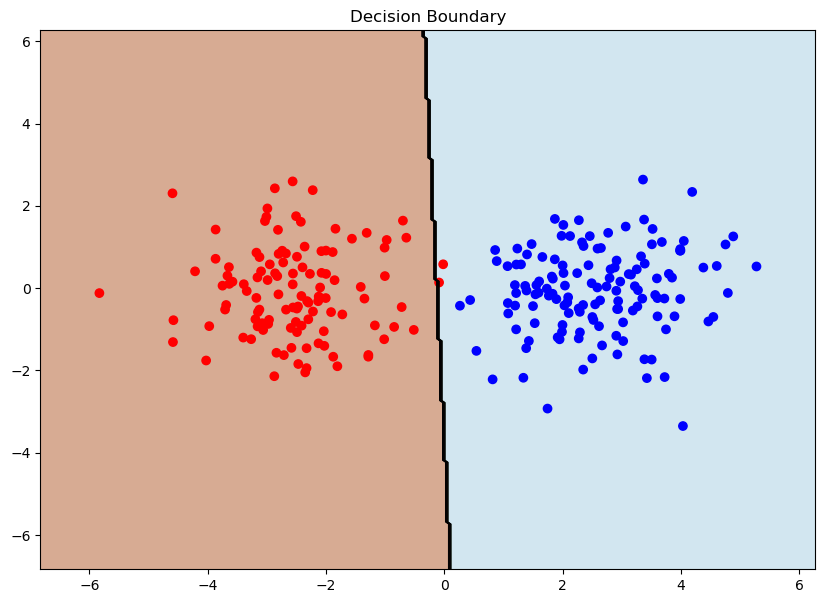

In [7]:
#Report Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM

In [8]:
linear_svm_model = LinearSVM(input_features=2)
losses = []
reg_param = 10
step_size = 0.05
train_linear_svm(linear_svm_model, train_loader, validation_loader, step_size, reg_param, losses, True)


Loss reduction after 1 epochs: -1.0
Loss reduction after 2 epochs: -0.02319241920239412
Loss reduction after 3 epochs: 0.00801919688107966
Loss reduction after 4 epochs: 0.01780085847251911
Loss reduction after 5 epochs: 0.015594621368539396
Loss reduction after 6 epochs: 0.01916272198133062
Loss reduction after 7 epochs: 0.016615634561776282
Loss reduction after 8 epochs: 0.017331204422599722
Loss reduction after 9 epochs: 0.014866727328576967
Loss reduction after 10 epochs: 0.013610717889243285
Loss reduction after 11 epochs: 0.010761541644393136
Loss reduction after 12 epochs: 0.007900913882145755
Loss reduction after 13 epochs: 0.009245816154815678
Loss reduction after 14 epochs: 0.008980061890948576
Loss reduction after 15 epochs: 0.01435548892539007
Loss reduction after 16 epochs: 0.008313829919379234
Loss reduction after 17 epochs: 0.01158538366162487
Loss reduction after 18 epochs: 0.011858252762521504
Loss reduction after 19 epochs: 0.010799091699316143
Loss reduction after 20

 Accuracy of model on test set: 100.0%


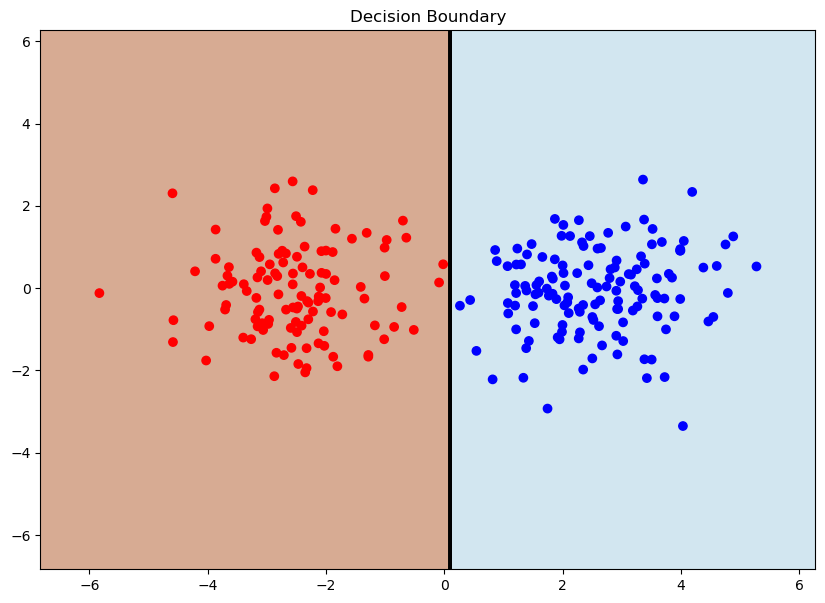

In [9]:
#Report Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_svm_model, test_set)

### Q 3.2.2

#### Naives Bayes Classifier

In [10]:
from sklearn.naive_bayes import GaussianNB

def draw_decision_boundary_for_sklearn(model, test_dataset):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()

    x_min, x_max = test_set.data.min() - 1, test_set.data.max() + 1
    y_min, y_max = test_set.data.min() - 1, test_set.data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05).astype(np.float32),
                        np.arange(y_min, y_max, 0.05).astype(np.float32))

    preds = model.predict(np.concatenate((xx.ravel().reshape(len(xx.ravel()), 1), yy.ravel().reshape(len(yy.ravel()), 1)), axis=1).reshape(len(yy.ravel()), 2))
    preds = preds >= 0.5*1.0
    preds = preds.reshape(xx.shape)
    plt.contourf(xx, yy, preds, cmap='Paired_r', alpha=0.5)
    plt.contour(xx, yy, preds, colors='k', linewidths=0.7)

    ax.scatter(test_dataset.data[:, 0], test_dataset.data[:, 1], c=test_dataset.labels ,cmap = clrs.ListedColormap(["red", "blue"]))
    plt.title("Decision Boundary")

    plt.show()
    return

naive_bayes_model = GaussianNB()
naive_bayes_model.fit(training_data, training_labels)
val_predictions = naive_bayes_model.predict(validation_data)
print(f"Validation Set Accuracy of Gaussian Naive Bayes classifier: \
    {float(torch.count_nonzero(validation_labels == torch.from_numpy(val_predictions).view(-1, 1)))/float(validation_data.shape[0])*100}")



Validation Set Accuracy of Gaussian Naive Bayes classifier:     99.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


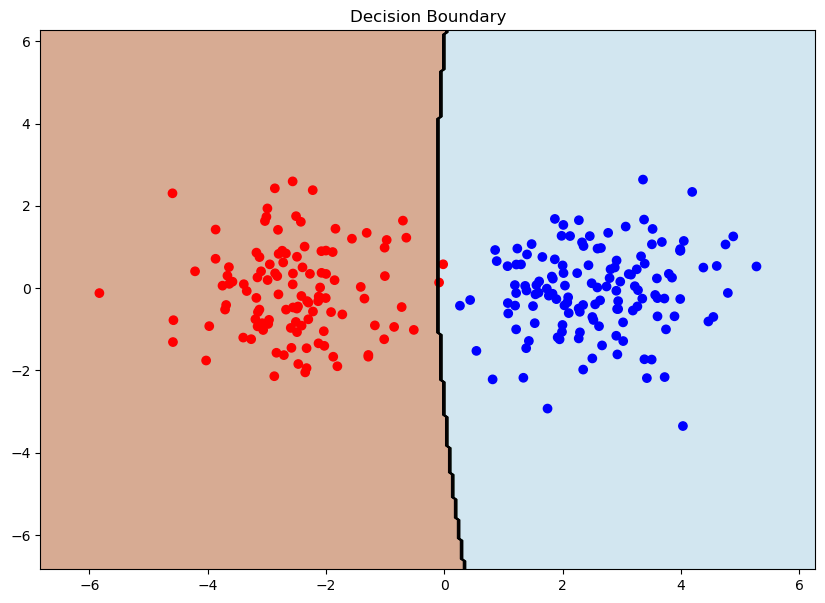

 Accuracy of model on test set: 99.2%


In [11]:
naive_bayes_test_predictions = naive_bayes_model.predict(test_data)

draw_decision_boundary_for_sklearn(naive_bayes_model, test_set)
naive_bayes_acc = get_accuracy(torch.from_numpy(naive_bayes_test_predictions).view(-1, 1), test_labels)
print(f" Accuracy of model on test set: {naive_bayes_acc*100}%")

#### KNN Decision Boundary and Accuracy

In [12]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)

knn_model.fit(training_data, training_labels)

val_predictions = knn_model.predict(validation_data)
print(f"Validation Set Accuracy of KNN classifier: \
    {float(torch.count_nonzero(validation_labels == torch.from_numpy(val_predictions).view(-1, 1)))/float(validation_data.shape[0])*100}")

Validation Set Accuracy of KNN classifier:     99.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


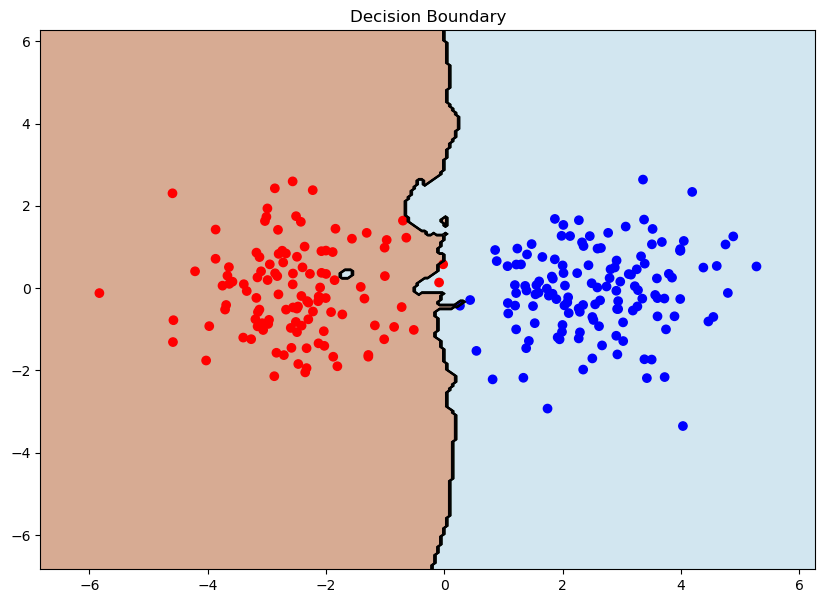

 Accuracy of model on test set: 99.2%


In [13]:
knn_test_predictions = knn_model.predict(test_data)

draw_decision_boundary_for_sklearn(knn_model, test_set)
knn_acc = get_accuracy(torch.from_numpy(knn_test_predictions).view(-1, 1), test_labels)
print(f" Accuracy of model on test set: {knn_acc*100}%")

### Q 3.2.3

In [14]:
mu_step_size = 0.20
mu = 1.0
losses = {}
losses["LinearRegression"] = []
losses["LinearSVM"] = []
losses["NaiveBayes"] = []
losses["KNN"] = []
x_axis = []

while mu <= 2.4:
    mu_tensor = torch.tensor([mu, 0])
    a  = []
    b = []
    positive_example_sampler = torch.distributions.MultivariateNormal(mu_tensor, torch.eye(2))
    negative_example_sampler = torch.distributions.MultivariateNormal(-mu_tensor, torch.eye(2))
    for _ in range(750):
        a.append(positive_example_sampler.sample().view(1,2))
        b.append(negative_example_sampler.sample().view(1,2))

    postive_data_points = torch.stack(a).view(750, 2)
    negative_data_points = torch.stack(b).view(750, 2)
    data_set = torch.cat((postive_data_points, negative_data_points))
    labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
    shuffle_index = torch.randperm(data_set.shape[0])
    data_set = data_set[shuffle_index]
    labels = labels[shuffle_index]
    permuted_indices = torch.randperm(data_set.shape[0])
    training_data = data_set[permuted_indices[:1000]]
    training_labels = labels[permuted_indices[:1000]]
    validation_data = data_set[permuted_indices[1000:1250]]
    validation_labels = labels[permuted_indices[1000:1250]]
    test_data = data_set[permuted_indices[1250:1500]]
    test_labels = labels[permuted_indices[1250:1500]] 

    training_set = Dataset(training_data, training_labels)
    train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
    validation_set = Dataset(validation_data, validation_labels)
    validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
    test_set = Dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)
    
    linear_lr_model = LinearLogisticRegression(input_features=2)
    linear_svm_model = LinearSVM(input_features=2)
    naive_bayes_model = GaussianNB()
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)
    l = []
    train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, l, False, 1000)
    train_linear_svm(linear_svm_model, train_loader, validation_loader, 0.05, 1.20, l, False, 1000)
    naive_bayes_model.fit(training_data, training_labels)
    knn_model.fit(training_data, training_labels)
    
    losses["LinearRegression"].append(get_accuracy(get_prediction(linear_lr_model, test_data), test_labels))
    losses["LinearSVM"].append(get_accuracy(get_prediction(linear_svm_model, test_data), test_labels))
    losses["NaiveBayes"].append(get_accuracy(torch.from_numpy(naive_bayes_model.predict(test_data)).view(-1, 1), test_labels))
    losses["KNN"].append(get_accuracy(torch.from_numpy(knn_model.predict(test_data)).view(-1, 1), test_labels))
    x_axis.append(mu)
    mu += mu_step_size
    
    

 Validation Set accuracy is: 82.0
 Validation Set accuracy is: 82.39999999999999


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 88.4
 Validation Set accuracy is: 86.8


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 94.0
 Validation Set accuracy is: 91.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 95.19999999999999
 Validation Set accuracy is: 95.19999999999999


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 95.6
 Validation Set accuracy is: 96.8


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 98.4
 Validation Set accuracy is: 98.0


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 98.4
 Validation Set accuracy is: 98.4


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


 Validation Set accuracy is: 98.8
 Validation Set accuracy is: 99.2


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


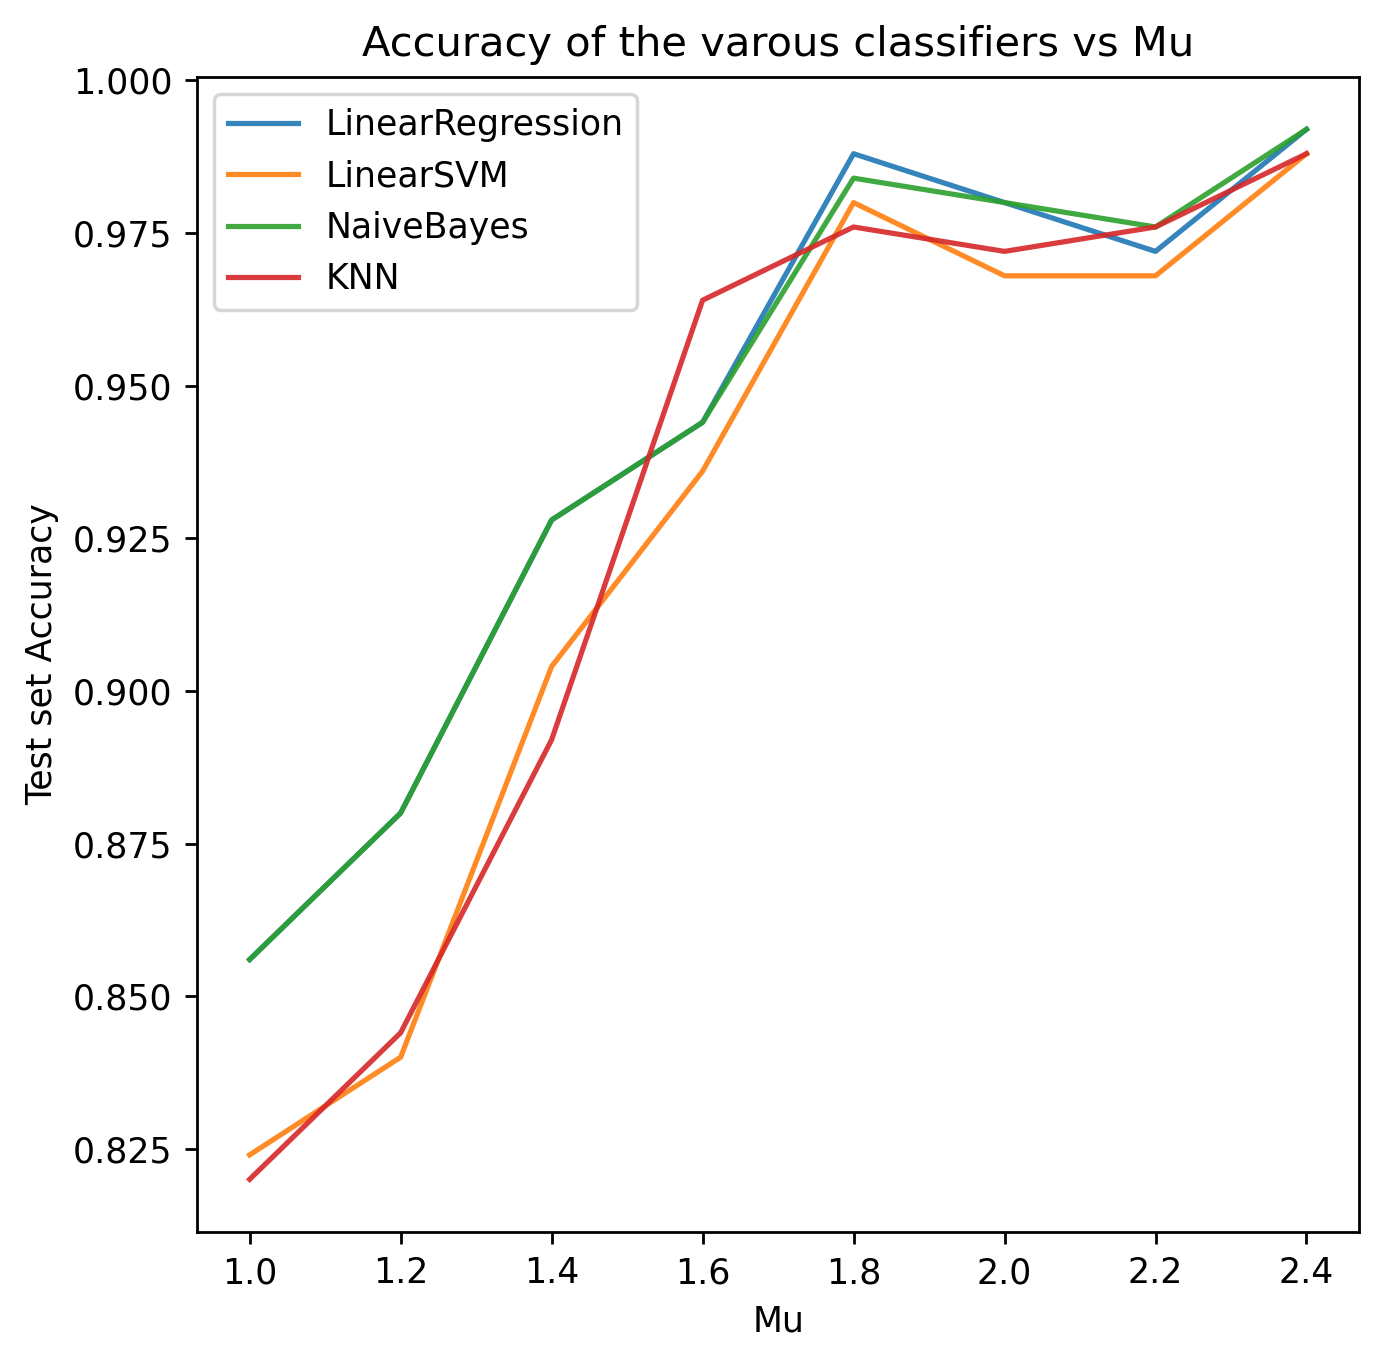

In [15]:
models = ["LinearRegression", "LinearSVM", "NaiveBayes", "KNN"]
colors = ['purple', 'yellow', 'red', 'teal']
fig = plt.figure(figsize=(6, 6), dpi=250)

ax = plt.axes()
ax.set_title("Accuracy of the varous classifiers vs Mu")
ax.set_xlabel("Mu")
ax.set_ylabel("Test set Accuracy")

for i, model in enumerate(models):
    ax.plot(x_axis, losses[model], label=model, alpha=0.90)
plt.legend(loc="upper left")
plt.show()    

## Q 3.3

In [16]:
from sklearn import datasets

In [35]:
data_set_tuples = datasets.make_circles(1500)

data_set = torch.zeros((len(data_set_tuples[0]), 2), dtype=torch.float)
labels = torch.zeros((len(data_set_tuples[0]), 1), dtype=torch.float)
data_set.copy_(torch.from_numpy(data_set_tuples[0].astype(np.float32)))
labels.copy_(torch.from_numpy(data_set_tuples[1].astype(np.float32)).view((len(data_set_tuples[0]), 1)))
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]]

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=250)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

### Q 3.3.1

#### Linear Regression Model

 Validation Set accuracy is: 45.6
 Accuracy of model on test set: 48.4%


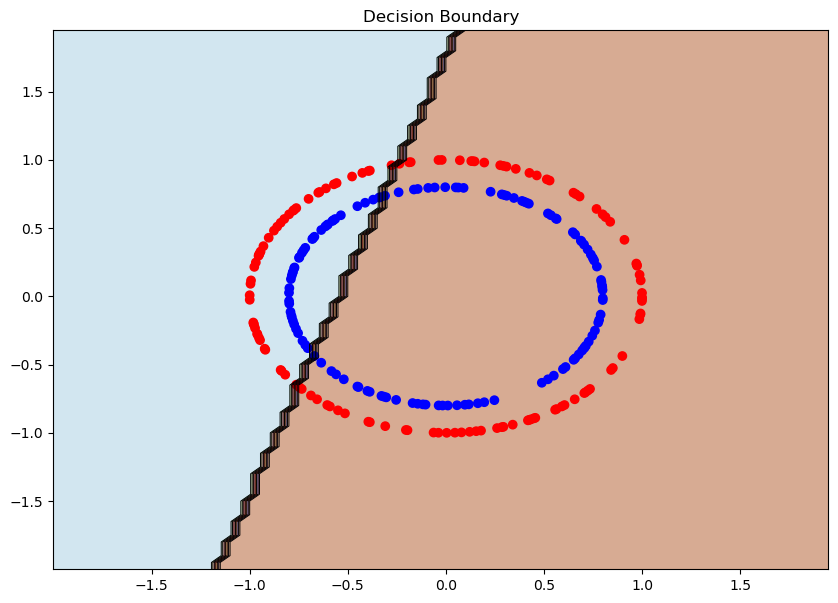

In [18]:
linear_lr_model = LinearLogisticRegression(input_features=2)
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

#Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM Model

 Validation Set accuracy is: 43.2
 Accuracy of model on test set: 46.0%


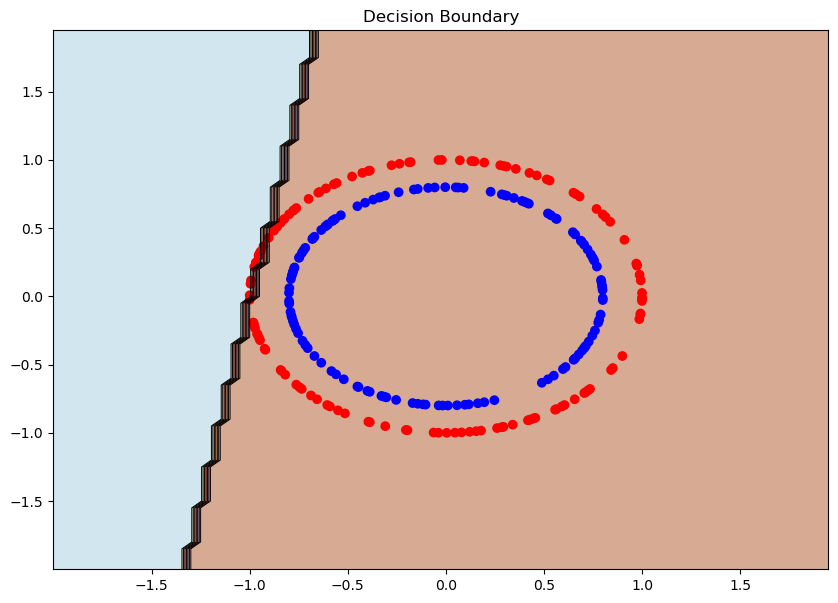

In [19]:
linear_svm_model = LinearSVM(input_features=2)
losses = []
reg_param = 1.5
step_size = 0.05
train_linear_svm(linear_svm_model, train_loader, validation_loader, step_size, reg_param, losses)

#Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_svm_model, test_set)

In [37]:
# Randomly select neighborhood to calculate kernel function from
permuted_indices = torch.randperm(training_data.shape[0])

 Validation Set accuracy is: 100.0
 Accuracy of model on test set: 100.0%


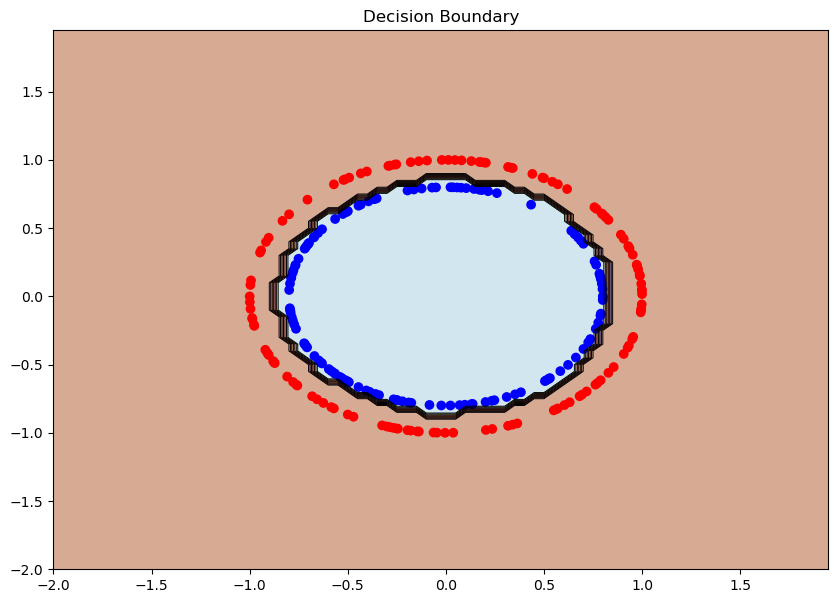

In [38]:
num_neighbors = 50
neighbors = training_data[permuted_indices[:num_neighbors]]
rbf_svm_model = KernelSVM(neighbors, 'rbf', sigma=math.sqrt(0.50))
losses = []

train_kernel_svm(rbf_svm_model, train_loader, validation_loader, 0.05, 1.5, losses)

#Accuracy
report_acc_decision_boundary(rbf_svm_model, test_loader)

#Decision Boundary
draw_decision_boundary(rbf_svm_model, test_set)

In [22]:
class hw4Model(torch.nn.Module):
    def __init__(self):
        super(hw4Model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 300, False),
            torch.nn.Sigmoid(),
            torch.nn.Linear(300, 1, False),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        output = self.layers(x)
        return output

In [23]:
def train_hw4_net(model, train_loader, validation_loader, learning_rate, losses, debug=False):
    threshold = 1e-5
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    criterion = torch.nn.BCELoss(reduction='mean')
    prev_loss = math.inf

    epoch = 1
    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x).view(x.shape[0], 1)
            #Get weights of the linear layer
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
            curr_loss =  criterion(val_predictions, val_labels)
        loss_reduction = curr_loss.item()/prev_loss - 1.0
        prev_loss = curr_loss.item()
        losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch +=1

    # Evaluate on validation set
    validation_accuracy = 0.
    for val_data, val_labels in validation_loader:
        val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
        validation_accuracy = get_accuracy(val_predictions, val_labels)
    print(f" Validation Set accuracy is: {validation_accuracy*100}")

    return

In [24]:
hw4_net = hw4Model()
losses = []
train_hw4_net(hw4_net, train_loader, validation_loader, 0.05, losses)

 Validation Set accuracy is: 47.199999999999996


 Accuracy of model on test set: 49.2%


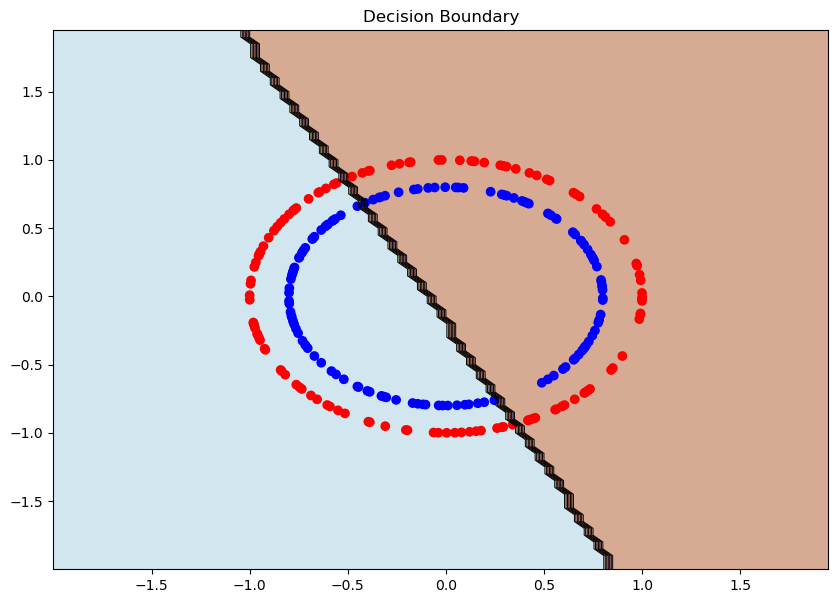

In [25]:
#Accuracy
report_acc_decision_boundary(hw4_net, test_loader)

#Decision Boundary
draw_decision_boundary(hw4_net, test_set)

In [26]:
from sklearn import neighbors
knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)

knn_model.fit(training_data, training_labels)

val_predictions = knn_model.predict(validation_data)
print(f"Validation Set Accuracy of KNN classifier: \
    {float(torch.count_nonzero(validation_labels == torch.from_numpy(val_predictions).view(-1, 1)))/float(validation_data.shape[0])*100}")

Validation Set Accuracy of KNN classifier:     100.0


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


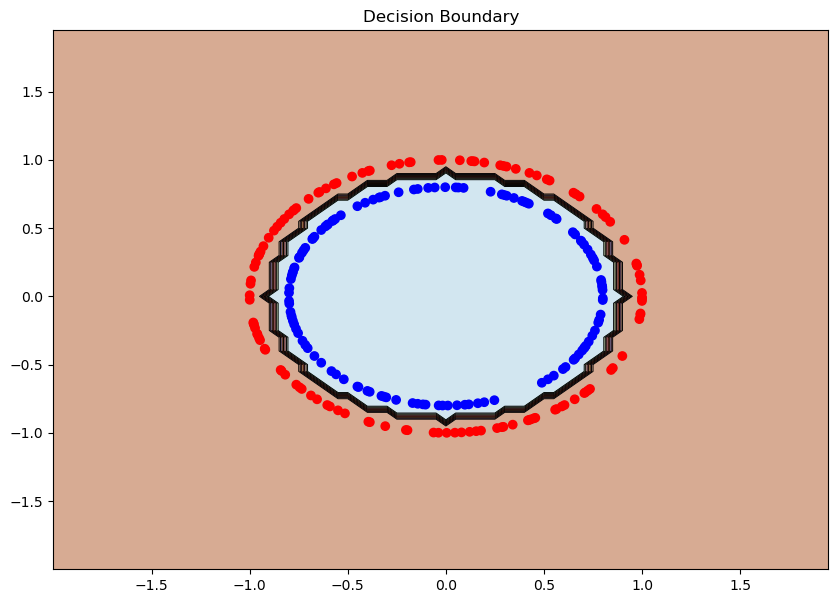

 Accuracy of model on test set: 100.0%


In [27]:
knn_test_predictions = knn_model.predict(test_data)

draw_decision_boundary_for_sklearn(knn_model, test_set)
knn_acc = get_accuracy(torch.from_numpy(knn_test_predictions).view(-1, 1), test_labels)
print(f" Accuracy of model on test set: {knn_acc*100}%")

### Q 3.4

In [28]:
import pandas as pd

df = datasets.load_breast_cancer()

data_set = torch.zeros((len(df['data']), 30), dtype=torch.float)
labels = torch.zeros((len(df['target']), 1), dtype=torch.float)
data_set.copy_(torch.from_numpy(df['data'].astype(np.float32)))
labels.copy_(torch.from_numpy(df['target'].astype(np.float32)).view((len(df['data']), 1)))
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:380]]
training_labels = labels[permuted_indices[:380]]
validation_data = data_set[permuted_indices[380:474]]
validation_labels = labels[permuted_indices[380:474]]
test_data = data_set[permuted_indices[474:569]]
test_labels = labels[permuted_indices[474:569]]

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

In [29]:
class hw4Model(torch.nn.Module):
    def __init__(self):
        super(hw4Model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(30, 300, False),
            torch.nn.Sigmoid(),
            torch.nn.Linear(300, 1, False),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        output = self.layers(x.view(-1, 30))
        return output


linear_svm_model = LinearSVM(input_features=30)
linear_lr_model = LinearLogisticRegression(input_features=30)

hw4_net = hw4Model()
losses = []
train_hw4_net(hw4_net, train_loader, validation_loader, 0.05, losses)

losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

losses = []
reg_param = 1.25
train_linear_svm(linear_svm_model, train_loader, validation_loader, 0.05, reg_param, losses)

 Validation Set accuracy is: 56.38297872340425
 Validation Set accuracy is: 43.61702127659575
 Validation Set accuracy is: 89.36170212765957


In [30]:
#Accuracy
report_acc_decision_boundary(hw4_net, test_loader)

 Accuracy of model on test set: 54.736842105263165%


In [31]:
#Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

 Accuracy of model on test set: 45.26315789473684%


In [32]:
#Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

 Accuracy of model on test set: 88.42105263157895%


In [33]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)

knn_model.fit(training_data, training_labels)

val_predictions = knn_model.predict(validation_data)
print(f"Validation Set Accuracy of KNN classifier: \
    {float(torch.count_nonzero(validation_labels == torch.from_numpy(val_predictions).view(-1, 1)))/float(validation_data.shape[0])*100}")

Validation Set Accuracy of KNN classifier:     91.48936170212765


/Users/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [34]:
knn_test_predictions = knn_model.predict(test_data)

knn_acc = get_accuracy(torch.from_numpy(knn_test_predictions).view(-1, 1), test_labels)
print(f" Accuracy of model on test set: {knn_acc*100}%")

 Accuracy of model on test set: 89.47368421052632%
